In [1]:
import os
import zipfile
import subprocess
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

from Bio import SeqIO
from collections import Counter
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

## Explore train, test and subject info

In [2]:
train_df = pd.read_csv( "Train.csv")
test_df = pd.read_csv("Test.csv")
train_subjects_df = pd.read_csv("Train_Subjects.csv")
ss = pd.read_csv("SampleSubmission.csv")

Number of unique subjects in train_df: 66
Number of unique SampleType in train_df: 4
Number of unique Files in train_df: 2901
Unique values in SampleType: ['Stool' 'Nasal' 'Mouth' 'Skin']
Average number of files per SubjectID in train_df: 43.95


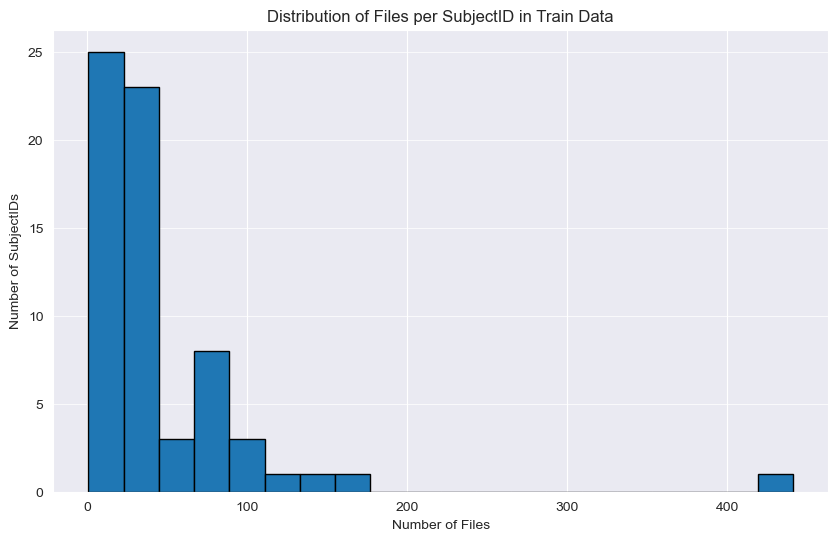

,filename,SampleType,SubjectID,SampleID
0,ID_LETPJN.mgb,Stool,Subject_BCUNIB,Sample_AFTIWE
1,ID_NTDGIW.mgb,Stool,Subject_UDAXIH,Sample_JQJVNK
2,ID_ZISBMF.mgb,Nasal,Subject_VRKADI,Sample_YJWGWW
3,ID_MDCVXU.mgb,Nasal,Subject_HIFZWD,Sample_VKEHZP
4,ID_SWAMNY.mgb,Stool,Subject_VGLNCV,Sample_NTDTEQ


In [3]:
print(f"Number of unique subjects in train_df: {train_df['SubjectID'].nunique()}")
print(f"Number of unique SampleType in train_df: {train_df['SampleType'].nunique()}")
print(f"Number of unique Files in train_df: {train_df['filename'].nunique()}")
print(f"Unique values in SampleType: {train_df['SampleType'].unique()}")
files_per_subject = train_df.groupby('SubjectID')['filename'].count().reset_index()
files_per_subject = files_per_subject.rename(columns={'filename': 'FileCount'})
average_files_per_subject = files_per_subject['FileCount'].mean()
print(f"Average number of files per SubjectID in train_df: {average_files_per_subject:.2f}")
plt.figure(figsize=(10, 6))
plt.hist(files_per_subject['FileCount'], bins=20, edgecolor='black')
plt.title('Distribution of Files per SubjectID in Train Data')
plt.xlabel('Number of Files')
plt.ylabel('Number of SubjectIDs')
plt.grid(axis='y', alpha=0.75)
plt.show()
train_df.head()

In [4]:
vc = train_df["SubjectID"].value_counts().reset_index()
vc.columns = ["SubjectID", "Count"]
vc.head(20)

,SubjectID,Count
0,Subject_UDAXIH,441
1,Subject_HBHSCC,159
2,Subject_CHDMIO,138
3,Subject_ASRHSH,111
4,Subject_VGLNCV,105
5,Subject_PZNGDD,100
6,Subject_FSIBDT,93
7,Subject_MMTOQI,85
8,Subject_HIFZWD,80
9,Subject_FNAFXK,80


In [5]:
print(f"Number of unique Files in test_df: {test_df['filename'].nunique()}")
test_df.head()

Number of unique Files in test_df: 1068


,filename
0,ID_YBNOYC.mgb
1,ID_HPVLUO.mgb
2,ID_DQGGYD.mgb
3,ID_XZBUJB.mgb
4,ID_KRPYRQ.mgb


## Explore fastq files

In [6]:
fastq_dir = "TrainFiles"
all_stats = []

for fname in os.listdir(fastq_dir):
    if not fname.endswith(".fastq"):
        continue

    path = os.path.join(fastq_dir, fname)
    read_lengths = []
    gc_counts = []
    nt_counts = Counter()

    try:
        for record in SeqIO.parse(path, "fastq"):
            seq = str(record.seq)
            read_lengths.append(len(seq))
            gc_counts.append(seq.count("G") + seq.count("C"))
            nt_counts.update(seq)

        if read_lengths:
            stats = {
                "file": fname,
                "num_reads": len(read_lengths),
                "avg_read_length": sum(read_lengths) / len(read_lengths),
                "avg_gc_content": sum(gc_counts) / sum(read_lengths),
                "A": nt_counts["A"],
                "T": nt_counts["T"],
                "G": nt_counts["G"],
                "C": nt_counts["C"]
            }
            all_stats.append(stats)

    except Exception as e:
        print(f"Error parsing {fname}: {e}")

df = pd.DataFrame(all_stats)
print(df.head())

              file  num_reads  avg_read_length  avg_gc_content         A  \
0  ID_AAFNOT.fastq      42840            124.5        0.552629    971747   
1  ID_AAXPTO.fastq      42814            400.0        0.539853   4605561   
2  ID_AAYKAN.fastq      21794            400.0        0.543314   2308491   
3  ID_ABEZNS.fastq     448014            124.5        0.529188  11374718   
4  ID_ABFFLP.fastq      15173            400.0        0.558125   1589191   

          T         G         C  
0   1414344   1432308   1515181  
1   3274727   5424731   3820581  
2   1672716   2777034   1959359  
3  14886123  14257696  15259206  
4   1092639   2005367   1382003  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2901 entries, 0 to 2900
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   file             2901 non-null   object 
 1   num_reads        2901 non-null   int64  
 2   avg_read_length  2901 non-null   float64
 3   avg_gc_content   2901 non-null   float64
 4   A                2901 non-null   int64  
 5   T                2901 non-null   int64  
 6   G                2901 non-null   int64  
 7   C                2901 non-null   int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 181.4+ KB


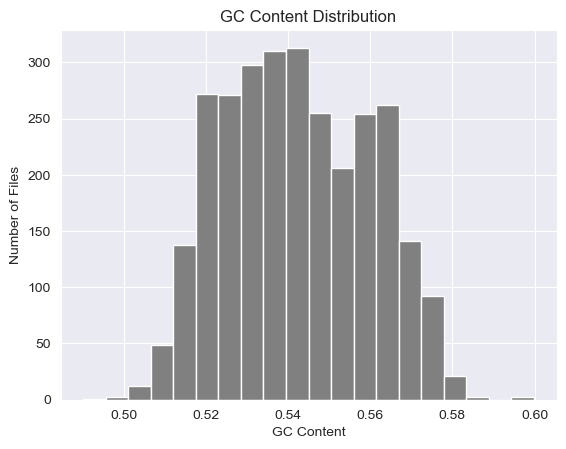

In [7]:
df.info()
plt.figure()
plt.hist(df["avg_gc_content"], bins=20, color='gray')
plt.title("GC Content Distribution")
plt.xlabel("GC Content")
plt.ylabel("Number of Files")
plt.show()

In [8]:
fastq_dir = "TrainFiles"
labels = ['Nasal', 'Stool', 'Mouth', 'Skin']

file_list = [f for f in os.listdir(fastq_dir) if f.endswith(".fastq")]

data = {
    "filename": file_list,
    "label": [random.choice(labels) for _ in file_list]
}

df_labels = pd.DataFrame(data)

df_labels = df_labels.sort_values("filename").reset_index(drop=True)

df_labels.head()

,filename,label
0,ID_AAFNOT.fastq,Mouth
1,ID_AAXPTO.fastq,Stool
2,ID_AAYKAN.fastq,Stool
3,ID_ABEZNS.fastq,Nasal
4,ID_ABFFLP.fastq,Stool


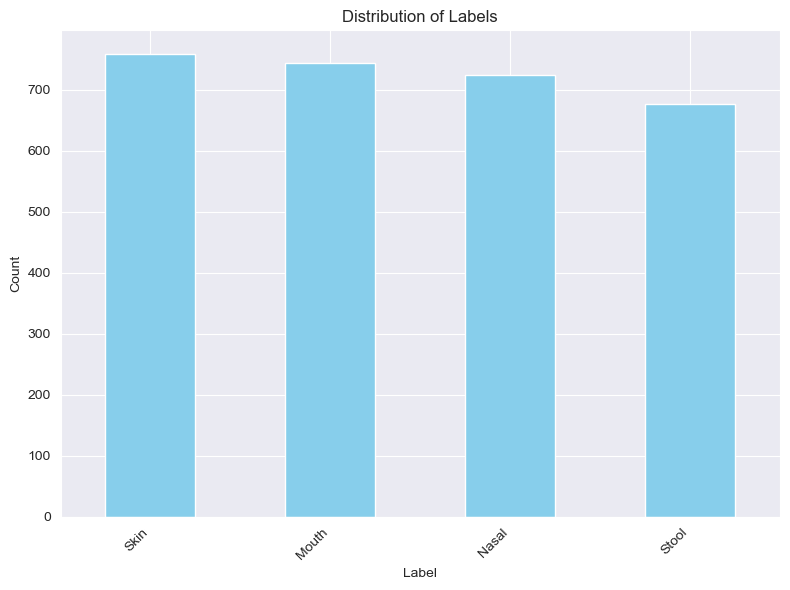

In [9]:
label_counts = df_labels['label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

## Extract features

In [10]:
def get_kmers(sequence, k=3):
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def extract_features_with_kmers(path, k=3):
    read_lengths = []
    gc_counts = []
    nt_counter = Counter()
    kmer_counter = Counter()

    for record in SeqIO.parse(path, "fastq"):
        seq = str(record.seq)
        read_lengths.append(len(seq))
        gc_counts.append(seq.count("G") + seq.count("C"))
        nt_counter.update(seq)
        kmer_counter.update(get_kmers(seq, k))

    if not read_lengths:
        return None

    total_len = sum(read_lengths)
    total_kmers = sum(kmer_counter.values())

    features = {
        "num_reads": len(read_lengths),
        "avg_read_len": total_len / len(read_lengths),
        "gc_content": sum(gc_counts) / total_len,
        "A": nt_counter["A"] / total_len,
        "T": nt_counter["T"] / total_len,
        "G": nt_counter["G"] / total_len,
        "C": nt_counter["C"] / total_len,
    }

    for kmer in sorted(kmer_counter):
        features[f'kmer_{kmer}'] = kmer_counter[kmer] / total_kmers

    return features

In [11]:
train_dir = "TrainFiles"
train_features = []

for _, row in df_labels.iterrows():
    fpath = os.path.join(train_dir, row["filename"])
    feats = extract_features_with_kmers(fpath, k=3)
    if feats:
        feats["filename"] = row["filename"]
        feats["label"] = row["label"]
        train_features.append(feats)

df_train = pd.DataFrame(train_features)

In [12]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif

le = LabelEncoder()
df_train["label_enc"] = le.fit_transform(df_train["label"])

X = df_train.drop(columns=["filename", "label", "label_enc"])
y = df_train["label_enc"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(mutual_info_classif, k=11)
X_new = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)

mi_scores = mutual_info_classif(X_scaled, y, discrete_features=False)
mi_series = pd.Series(mi_scores, index=X.columns)

N = 10
top_features = mi_series.sort_values(ascending=False).head(N)

print("Top features by mutual information:")
print(top_features)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_top = X_scaled_df[top_features.index.tolist()]

Selected features: Index(['kmer_AGT', 'kmer_ATC', 'kmer_ATG', 'kmer_CAA', 'kmer_CCT', 'kmer_CGC',
       'kmer_GCC', 'kmer_GGA', 'kmer_GGG', 'kmer_TAT', 'kmer_TCT'],
      dtype='object')
Top features by mutual information:
kmer_CGC    0.036032
kmer_CAA    0.022777
kmer_CCT    0.020106
kmer_GGG    0.018003
kmer_GGA    0.017898
kmer_ATC    0.017350
kmer_AGT    0.015701
kmer_TAT    0.015665
kmer_GCC    0.013416
kmer_ATG    0.012996
dtype: float64


## Random Forrest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_val, y_train, y_val = train_test_split(X_top, y, stratify=y, random_state=42)

clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=le.classes_))
print(clf.feature_importances_)

              precision    recall  f1-score   support

       Mouth       0.28      0.31      0.29       186
       Nasal       0.23      0.22      0.23       181
        Skin       0.25      0.27      0.26       190
       Stool       0.17      0.14      0.15       169

    accuracy                           0.24       726
   macro avg       0.23      0.23      0.23       726
weighted avg       0.23      0.24      0.23       726

[0.09970008 0.09901242 0.10053666 0.09706894 0.10000271 0.10287607
 0.10128001 0.09855887 0.10144218 0.09952204]


## XGboost

In [20]:
import xgboost as xgb

clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=le.classes_))

[0]	validation_0-mlogloss:1.39029
[1]	validation_0-mlogloss:1.39736
[2]	validation_0-mlogloss:1.40297
              precision    recall  f1-score   support

       Mouth       0.24      0.24      0.24       186
       Nasal       0.29      0.34      0.31       181
        Skin       0.31      0.42      0.35       190
       Stool       0.18      0.07      0.10       169

    accuracy                           0.27       726
   macro avg       0.25      0.27      0.25       726
weighted avg       0.26      0.27      0.26       726



## MLP Classifier

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

input_dim = X_train.shape[1]

model = Sequential([
    Dense(512, input_dim=input_dim, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(4, activation='softmax')  # 4 classes
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2772 - loss: 2.0270 - val_accuracy: 0.2624 - val_loss: 1.4164
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2672 - loss: 1.8738 - val_accuracy: 0.2430 - val_loss: 1.4496
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2854 - loss: 1.6674 - val_accuracy: 0.2387 - val_loss: 1.4753
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2304 - loss: 1.7137 - val_accuracy: 0.2301 - val_loss: 1.4293
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2503 - loss: 1.6374 - val_accuracy: 0.2344 - val_loss: 1.4667
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2456 - loss: 1.5682 - val_accuracy: 0.2366 - val_loss: 1.4604


In [17]:
test_dir = "TestFiles"
test_files = [f for f in os.listdir(test_dir) if f.endswith(".fastq")]

test_features = []
for fname in test_files:
    path = os.path.join(test_dir, fname)
    feats = extract_features_with_kmers(path)
    if feats:
        feats["filename"] = fname
        test_features.append(feats)

df_test = pd.DataFrame(test_features)

In [21]:
X_test = df_test[feature_cols]
probs = clf.predict_proba(X_test)

probs_df = pd.DataFrame(probs, columns=le.inverse_transform(clf.classes_))
probs_df.insert(0, "filename", df_test["filename"])
probs_df.head()

TypeError: unhashable type: 'dict'

In [34]:
required_order = ["filename", "Mouth", "Nasal", "Skin", "Stool"]
for col in required_order[1:]:
    if col not in probs_df.columns:
        probs_df[col] = 0.0

probs_df = probs_df[required_order]
probs_df["filename"] = probs_df["filename"].str.replace(".fastq", "", regex=False)

probs_df.head()
probs_df.to_csv("test_predictions_probs.csv", index=False)

In [93]:
import os

decoded_dir = "TestFiles"

for f in os.listdir(decoded_dir):
    if f.endswith(".fastq"):
        size = os.path.getsize(os.path.join(decoded_dir, f))
        if size < 1000:  # adjust threshold depending on expected size
            print(f"⚠️ Small file: {f} -> {size} bytes")
